In [1]:
import torch
import torch.distributions as D
import torch.nn as nn
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import animation
import seaborn as sns

/tmp/ipykernel_488307/2445544741.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_p0, label='p0')
/tmp/ipykernel_488307/2445544741.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_p1, label='p1')


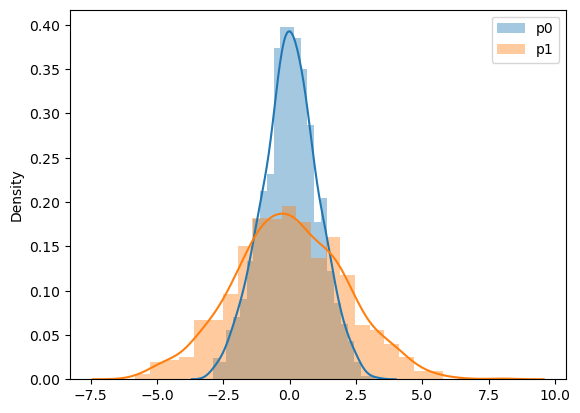

In [2]:
p0=D.Normal(0,1)
p1=D.Normal(0,2)

sample_p0=p0.sample((1000,))
sample_p1=p1.sample((1000,))
sample_p0=sample_p0.numpy()
sample_p1=sample_p1.numpy()

sns.distplot(sample_p0, label='p0')
sns.distplot(sample_p1, label='p1')
plt.legend()
plt.show()

In [3]:
#define neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1=nn.Linear(1, 100)
        self.fc2=nn.Linear(100, 100)
        self.fc3=nn.Linear(100, 1)
        self.partition=nn.Parameter(torch.tensor([1.], requires_grad=True))
    
    def forward(self, x):
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=self.fc3(x)
        return - x - torch.log(self.partition)

In [4]:
#nce value function

def value(energy, noise, x, gen):
    logp_x = energy(x)  # logp(x)
    try:
        logq_x = noise.log_prob(x)  # logq(x)
    except:
        logq_x = noise.log_prob(x.clone().detach().cpu()).cuda()
    logp_gen = energy(gen)  # logp(x̃)
    try:
        logq_gen = noise.log_prob(gen)  # logq(x̃)
    except:
        logq_gen = noise.log_prob(gen.clone().detach().cpu()).cuda()
    value_data = logp_x - torch.logsumexp(torch.cat([logp_x, logq_x], dim=1), dim=1, keepdim=True)  # log[p(x)/(p(x) + q(x))]
    value_gen = logq_gen - torch.logsumexp(torch.cat([logp_gen, logq_gen], dim=1), dim=1, keepdim=True)  # log[q(x̃)/(p(x̃) + q(x̃))]

    v = value_data.mean() + value_gen.mean()

    r_x = torch.sigmoid(logp_x - logq_x)
    r_gen = torch.sigmoid(logq_gen - logp_gen)

    acc = ((r_x > 1/2).sum() + (r_gen > 1/2).sum()).cpu().numpy() / (len(x) + len(gen))

    return -v,  acc

In [62]:
# bar overlap computation
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

@torch.no_grad
def bar_overlap(energy_model, energy_data, noise, x, gen, beta = 0.0, maxiter = 100):
    try:
        logq_gen = noise.log_prob(gen)  # logq(x̃)
    except:
        logq_gen = noise.log_prob(gen.clone().detach().cpu()).cuda()
    overlap = 0
    output = 0.0
    iters = 0
    while maxiter > iters:
        data_overlap = 1 - torch.mean(sigmoid(energy_data(x) - energy_model(x) - beta))
        #data_term = torch.log(data_overlap)
        model_overlap = torch.mean(sigmoid(energy_data(gen) - energy_model(gen) - beta) * torch.exp(energy_model(gen) - logq_gen))
        # model_term = - torch.log(torch.mean(sigmoid(energy_data(gen) - energy_model(gen) - beta) * torch.exp(energy_model(gen) - logq_gen)))
        # print(beta, data_overlap, model_overlap, iters)
        output = beta - (data_overlap - model_overlap)
        overlap = 0.5 - data_overlap
        iters += 1
        if torch.linalg.norm(output - beta) < 1e-6:
              break
        beta = output
    return overlap, output, iters

In [63]:
#nce training 
def train(p0,p1):
    model=Net().cuda()
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-5)
    training_iterations=10000
    batch_size=10000
    total_bar_iter = 0
    overlap = 1
    log_z = 0
    bar_iter = 0
    for i in range(training_iterations):
        optimizer.zero_grad()
        z=p1.sample((batch_size, 1)).cuda()
        if i % 100 == 0:
            overlap, log_z, bar_iter = bar_overlap(model, p1.log_prob, p0, z, p0.sample((batch_size,1)).cuda())
        total_bar_iter += bar_iter
        loss, acc=value(model, p0, z, p0.sample((batch_size,1 )).cuda())
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('Iteration: %s, Loss: %s, Accuracy: %s, Overlap: %s, Bar Iter: %s' % (i, loss.item(), acc, overlap.item(), bar_iter))
    return model
model=train(p0, p1)

Iteration: 0, Loss: 1.7577179670333862, Accuracy: 0.5, Overlap: -0.35685181617736816, Bar Iter: 7
Iteration: 100, Loss: 1.684336543083191, Accuracy: 0.5, Overlap: -0.34422993659973145, Bar Iter: 7
Iteration: 200, Loss: 1.6061806678771973, Accuracy: 0.5, Overlap: -0.3137204647064209, Bar Iter: 8
Iteration: 300, Loss: 1.5508534908294678, Accuracy: 0.5, Overlap: -0.31697148084640503, Bar Iter: 8
Iteration: 400, Loss: 1.495155930519104, Accuracy: 0.5, Overlap: -0.25120484828948975, Bar Iter: 10
Iteration: 500, Loss: 1.4223518371582031, Accuracy: 0.5, Overlap: -0.22697162628173828, Bar Iter: 10
Iteration: 600, Loss: 1.3891515731811523, Accuracy: 0.5, Overlap: -0.21989572048187256, Bar Iter: 10
Iteration: 700, Loss: 1.3382431268692017, Accuracy: 0.5, Overlap: -0.16502392292022705, Bar Iter: 10
Iteration: 800, Loss: 1.3072775602340698, Accuracy: 0.5, Overlap: -0.13002991676330566, Bar Iter: 12
Iteration: 900, Loss: 1.2810425758361816, Accuracy: 0.5591, Overlap: -0.09680938720703125, Bar Iter:

In [64]:
batch_size=10000
@torch.no_grad
def bar_overlap_debug(energy_model, energy_data, noise, x, gen, beta = 0.0, maxiter = 100):
    try:
        logq_gen = noise.log_prob(gen)  # logq(x̃)
    except:
        logq_gen = noise.log_prob(gen.clone().detach().cpu()).cuda()
    overlap = 0
    output = 0.0
    iters = 0
    while maxiter > iters:
        data_overlap = 1 - torch.mean(sigmoid(energy_data(x) - energy_model(x) - beta))
        #data_term = torch.log(data_overlap)
        model_overlap = torch.mean(sigmoid(energy_data(gen) - energy_model(gen) - beta) * torch.exp(energy_model(gen) - logq_gen))
        # model_term = - torch.log(torch.mean(sigmoid(energy_data(gen) - energy_model(gen) - beta) * torch.exp(energy_model(gen) - logq_gen)))
        print(beta, data_overlap, model_overlap, iters)
        output = beta - (data_overlap - model_overlap)
        overlap = 0.5 - data_overlap
        iters += 1
        if torch.linalg.norm(output - beta) < 1e-6:
              break
        beta = output
    return overlap, output, iters

bar_overlap_debug(model, p1.log_prob, p0, p1.sample((batch_size,1)).cuda(), p0.sample((batch_size,1)).cuda())

0.0 tensor(0.5080, device='cuda:0') tensor(0.4874, device='cuda:0') 0
tensor(-0.0206, device='cuda:0') tensor(0.5029, device='cuda:0') tensor(0.4925, device='cuda:0') 1
tensor(-0.0311, device='cuda:0') tensor(0.5003, device='cuda:0') tensor(0.4950, device='cuda:0') 2
tensor(-0.0364, device='cuda:0') tensor(0.4990, device='cuda:0') tensor(0.4963, device='cuda:0') 3
tensor(-0.0390, device='cuda:0') tensor(0.4983, device='cuda:0') tensor(0.4970, device='cuda:0') 4
tensor(-0.0404, device='cuda:0') tensor(0.4980, device='cuda:0') tensor(0.4973, device='cuda:0') 5
tensor(-0.0411, device='cuda:0') tensor(0.4978, device='cuda:0') tensor(0.4975, device='cuda:0') 6
tensor(-0.0414, device='cuda:0') tensor(0.4977, device='cuda:0') tensor(0.4975, device='cuda:0') 7
tensor(-0.0416, device='cuda:0') tensor(0.4977, device='cuda:0') tensor(0.4976, device='cuda:0') 8
tensor(-0.0417, device='cuda:0') tensor(0.4977, device='cuda:0') tensor(0.4976, device='cuda:0') 9
tensor(-0.0417, device='cuda:0') tensor

(tensor(0.0024, device='cuda:0'), tensor(-0.0418, device='cuda:0'), 16)

In [18]:
print(model.partition.item())

1.014740228652954


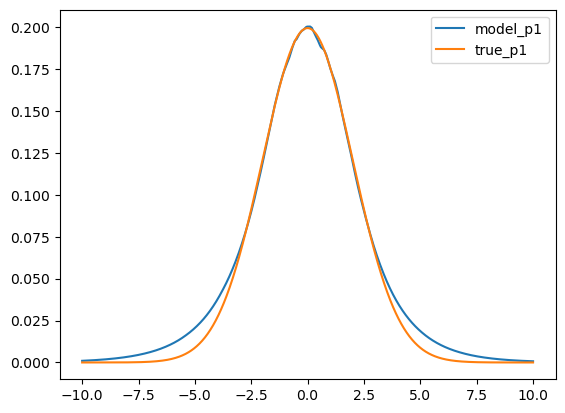

In [19]:
#plot model energy across x axis
x=np.linspace(-10, 10, 1000)
x=torch.Tensor(x).cuda().unsqueeze(1)
true_energy=p1.log_prob(x).detach().cpu().squeeze().numpy()
energy=model(x).detach().cpu().squeeze().numpy()
x=x.cpu().squeeze().numpy()
plt.plot(x, np.exp(energy),label='model_p1')
plt.plot(x, np.exp(true_energy), label='true_p1')
plt.legend()
plt.show()

# Unimodal to bimodal

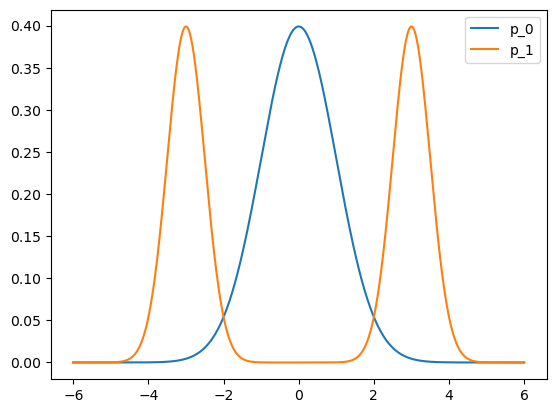

In [53]:
def build_gmm(n_modes, means=None, vars=None):

    if means is None:
        means = torch.randn(n_modes,1)
    if vars is None:
        vars = torch.rand(n_modes,1)
        vars[:,1] = vars[:,0]

    mix = D.Categorical(torch.ones(n_modes,))
    comp = D.Independent(D.Normal(means, vars), 1)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm


p_0_means = torch.zeros(1)
p_0_vars = torch.ones(1)
p_0 = D.Normal(p_0_means, p_0_vars)


p_1_means = torch.tensor([[3], [ -3]]).float()
p_1_vars = torch.ones(2,1)*0.5
p_1 = build_gmm(2, p_1_means, p_1_vars)

x = torch.linspace(-6, 6, 1000).unsqueeze(1)
plt.plot(x, torch.exp(p_0.log_prob(x)), label='p_0')
plt.plot(x, torch.exp(p_1.log_prob(x)), label='p_1')
# plt.gca().set_aspect('equal', adjustable='box')
# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()
plt.legend()
plt.show()

In [54]:
model=train(p_0, p_1)
print(model.partition.item())


Iteration: 0, Loss: 1.7967603206634521, Accuracy: 0.5


Iteration: 100, Loss: 1.7223995923995972, Accuracy: 0.5
Iteration: 200, Loss: 1.6613216400146484, Accuracy: 0.5
Iteration: 300, Loss: 1.5832459926605225, Accuracy: 0.5
Iteration: 400, Loss: 1.5121911764144897, Accuracy: 0.5
Iteration: 500, Loss: 1.4452838897705078, Accuracy: 0.5
Iteration: 600, Loss: 1.3766900300979614, Accuracy: 0.5
Iteration: 700, Loss: 1.3152185678482056, Accuracy: 0.5
Iteration: 800, Loss: 1.2493976354599, Accuracy: 0.5
Iteration: 900, Loss: 1.176522970199585, Accuracy: 0.5
Iteration: 1000, Loss: 1.118747591972351, Accuracy: 0.5
Iteration: 1100, Loss: 1.0660632848739624, Accuracy: 0.5
Iteration: 1200, Loss: 1.0246217250823975, Accuracy: 0.60485
Iteration: 1300, Loss: 0.9684858918190002, Accuracy: 0.66905
Iteration: 1400, Loss: 0.9336013793945312, Accuracy: 0.7089
Iteration: 1500, Loss: 0.8977780342102051, Accuracy: 0.7494
Iteration: 1600, Loss: 0.8591397404670715, Accuracy: 0.79275
Iteration: 1700, Loss: 0.8207611441612244, Accuracy: 0.8307
Iteration: 1800, Loss: 0

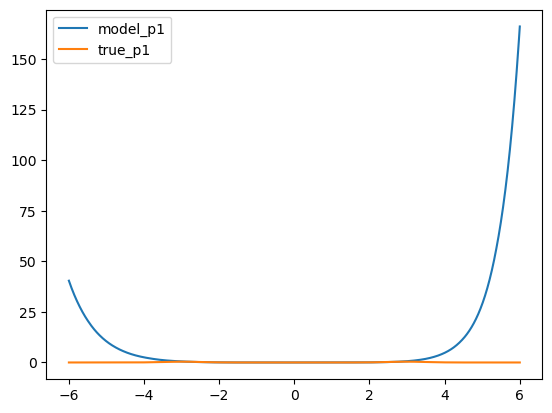

In [55]:
x=np.linspace(-6, 6, 1000)
x=torch.Tensor(x).cuda().unsqueeze(1)
true_energy=p_1.log_prob(x.detach().cpu()).squeeze().numpy()
energy=model(x).detach().cpu().squeeze().numpy()
x=x.cpu().squeeze().numpy()
plt.plot(x, np.exp(energy),label='model_p1')
plt.plot(x, np.exp(true_energy), label='true_p1')
plt.legend()